## Home vs. Away Performance Analysis

### Overview
This notebook analyzes the performance of Partizan Mozzart Bet Belgrade players and the team in home versus away games during the 2022-2023 EuroLeague season. The analysis focuses on key metrics such as points, valuation (Performance Index Rating, or PIR), and plus/minus to determine if there is a significant home-court advantage. The investigation includes:
- Comparing player performance at home versus away.
- Visualizing differences in player metrics.
- Testing for statistical significance of home-court advantage at the team level.

In [2]:
import pandas as pd

file_path = "../data/partizan_2022_cleaned.csv"

df = pd.read_csv(file_path)

Prepare the data by filtering out team totals and adding an indicator to distinguish between home and away games.

In [3]:
# filter 
players = df[df['player'] != 'PARTIZAN MOZZART BET BELGRADE'].copy()
active_players = players[players['is_playing'] == True].copy()

# add 'is_home' column: True if game starts with 'PAR'
players['is_home'] = players['game'].apply(lambda x: x.startswith('PAR'))
active_players['is_home'] = active_players['game'].apply(lambda x: x.startswith('PAR'))

Compute average performance metrics (points, valuation, plus/minus) for each player at home and away, and calculate the differences to identify players who perform better at home.

In [4]:
# calculate averages for home and away
home_away_stats = active_players.groupby(['player', 'is_home']).agg({
    'points': 'mean',
    'valuation': 'mean',
    'plus_minus': 'mean'
}).unstack()

# rename columns for clarity
home_away_stats.columns = [f"{col[0]}_{'home' if col[1] else 'away'}" for col in home_away_stats.columns]

# compute differences (home - away)
home_away_stats['points_diff'] = home_away_stats['points_home'] - home_away_stats['points_away']
home_away_stats['valuation_diff'] = home_away_stats['valuation_home'] - home_away_stats['valuation_away']
home_away_stats['plus_minus_diff'] = home_away_stats['plus_minus_home'] - home_away_stats['plus_minus_away']

# filter for players with at least 5 home and 5 away games
min_games = 5
home_away_stats = home_away_stats[(active_players.groupby('player')['is_home'].sum() >= min_games) & 
                                  (active_players.groupby('player')['is_home'].apply(lambda x: (~x).sum()) >= min_games)]



# print("\nTop 5 Players by Points Increase at Home:")
# print(home_away_stats.sort_values('points_diff', ascending=False)[['points_home', 'points_away', 'points_diff']].head(5))

print("\nTop 5 Players by Valuation Increase at Home:")
print(home_away_stats.sort_values('valuation_diff', ascending=False)[['valuation_home', 'valuation_away', 'valuation_diff']].head(5))

# print("\nTop 5 Players by Plus-Minus Increase at Home:")
# print(home_away_stats.sort_values('plus_minus_diff', ascending=False)[['plus_minus_home', 'plus_minus_away', 'plus_minus_diff']].head(5))



Top 5 Players by Valuation Increase at Home:
                    valuation_home  valuation_away  valuation_diff
player                                                            
Madar Yam                 8.473684        1.526316        6.947368
Lessort Mathias          22.055556       16.500000        5.555556
Papapetrou Ioannis        6.473684        3.631579        2.842105
Trifunovic Uros           2.000000        1.312500        0.687500
Vukcevic Tristan          0.250000       -0.333333        0.583333


The top 5 players with the greatest valuation increase at home are identified, with Yam Madar showing the largest improvement (6.95), followed by Mathias Lessort (5.56).

Verify the valuation calculation for Yam Madar to ensure accuracy.

In [5]:
# filter Madar Yam’s data
madar = active_players[active_players['player'] == 'Madar Yam']

# split home and away
madar_home = madar[madar['is_home']]
madar_away = madar[~madar['is_home']]

# calculate means
home_mean = madar_home['valuation'].mean()
away_mean = madar_away['valuation'].mean()
diff = home_mean - away_mean



print(f"Madar Yam Validation:")
print(f"Home Valuation Mean: {home_mean:.6f}")
print(f"Away Valuation Mean: {away_mean:.6f}")
print(f"Valuation Difference: {diff:.6f}")
print(f"Number of Home Games: {len(madar_home)}")
print(f"Number of Away Games: {len(madar_away)}")

Madar Yam Validation:
Home Valuation Mean: 8.473684
Away Valuation Mean: 1.526316
Valuation Difference: 6.947368
Number of Home Games: 19
Number of Away Games: 19


The validation confirms the earlier calculation: Yam Madar has a significantly higher valuation at home (8.47) compared to away (1.53), with a difference of 6.95. He played 19 home and 19 away games, providing a robust sample.

Create a bar plot to visually compare the home and away valuations for the top 5 players by valuation difference.

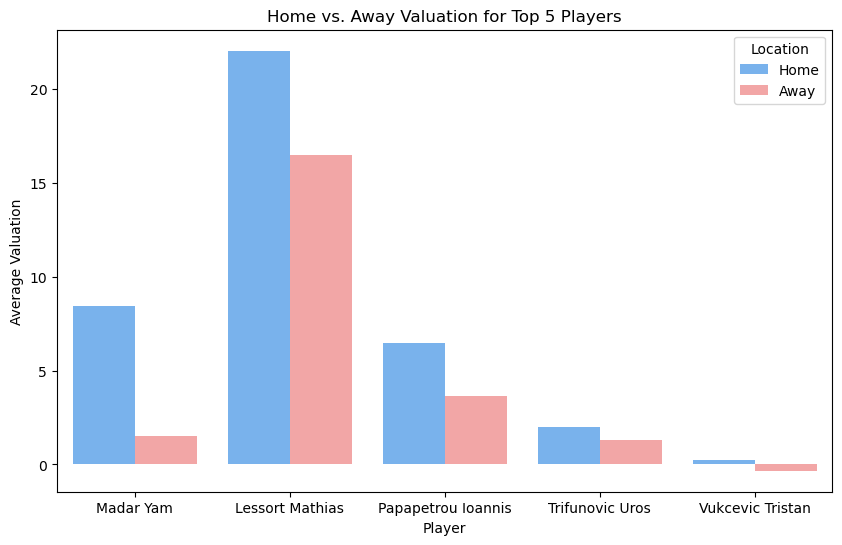

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# get top 5 players by valuation difference (home - away)
top_home_valuation = home_away_stats.sort_values('valuation_diff', ascending=False).head(5)

# prepare data in long format for valuation
data = pd.melt(top_home_valuation.reset_index(), id_vars=['player'], 
               value_vars=['valuation_home', 'valuation_away'], 
               var_name='location', value_name='valuation')
data['location'] = data['location'].replace({'valuation_away': 'Away', 'valuation_home': 'Home'})




plt.figure(figsize=(10, 6))
sns.barplot(x='player', y='valuation', hue='location', data=data, palette=['#66B2FF', '#FF9999'])
plt.title('Home vs. Away Valuation for Top 5 Players')
plt.xlabel('Player')
plt.ylabel('Average Valuation')
plt.legend(title='Location')
plt.show()

A bar plot is generated, showing that players like Yam Madar and Mathias Lessort have significantly higher valuations at home compared to away, with Madar’s difference being the most pronounced.

Identify the top 5 players with the greatest increases in points and plus/minus at home.

In [7]:
print("\nTop 5 Players by Points Increase at Home:")
print(home_away_stats.sort_values('points_diff', ascending=False)[['points_home', 'points_away', 'points_diff']].head(5))

print("\nTop 5 Players by Plus-Minus Increase at Home:")
print(home_away_stats.sort_values('plus_minus_diff', ascending=False)[['plus_minus_home', 'plus_minus_away', 'plus_minus_diff']].head(5))


Top 5 Players by Points Increase at Home:
                    points_home  points_away  points_diff
player                                                   
Madar Yam              8.263158     3.368421     4.894737
Lessort Mathias       13.111111    11.000000     2.111111
Papapetrou Ioannis     6.105263     4.631579     1.473684
Vukcevic Tristan       1.500000     0.500000     1.000000
Trifunovic Uros        2.105263     1.250000     0.855263

Top 5 Players by Plus-Minus Increase at Home:
                    plus_minus_home  plus_minus_away  plus_minus_diff
player                                                               
Papapetrou Ioannis         4.105263        -6.368421        10.473684
Lessort Mathias            7.666667        -1.300000         8.966667
Punter Kevin               7.588235        -0.900000         8.488235
Leday Zach                 6.263158        -1.950000         8.213158
Exum Dante                 4.473684         0.842105         3.631579


- **Points:** Yam Madar leads with a 4.89-point increase at home, followed by Mathias Lessort (2.11).  
- **Plus/Minus:** Ioannis Papapetrou shows the largest increase (10.47), improving from -6.37 away to 4.11 at home. Lessort, Punter, Leday, and Exum also perform better at home.

Create a bar plot to visually compare the home and away plus/minus for the top 5 players by plus/minus difference.

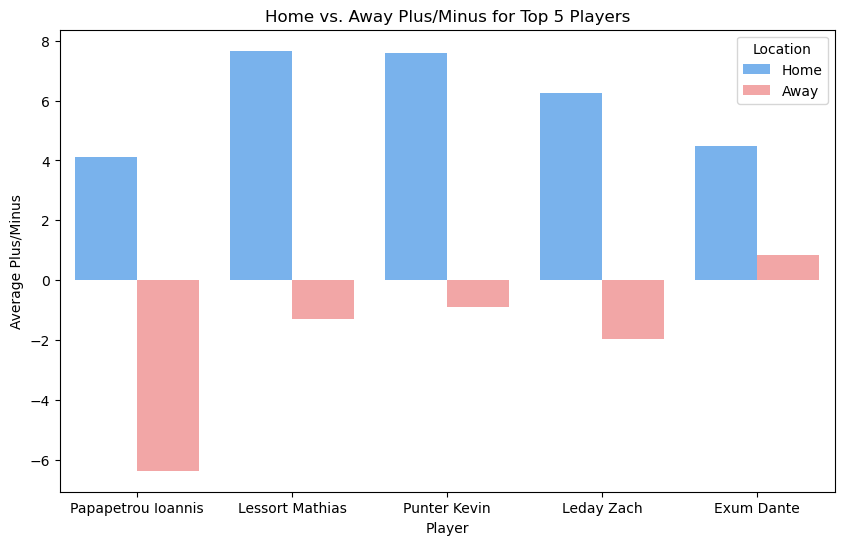

In [8]:
# get top 5 players by plus/minus difference (home - away)
top_home_plus_minus = home_away_stats.sort_values('plus_minus_diff', ascending=False).head(5)

# prepare data in long format for plus/minus
data = pd.melt(top_home_plus_minus.reset_index(), id_vars=['player'], 
               value_vars=['plus_minus_home', 'plus_minus_away'], 
               var_name='location', value_name='plus_minus')
data['location'] = data['location'].replace({'plus_minus_away': 'Away', 'plus_minus_home': 'Home'})




plt.figure(figsize=(10, 6))
sns.barplot(x='player', y='plus_minus', hue='location', data=data, palette=['#66B2FF', '#FF9999'])
plt.title('Home vs. Away Plus/Minus for Top 5 Players')
plt.xlabel('Player')
plt.ylabel('Average Plus/Minus')
plt.legend(title='Location')
plt.show()

A bar plot is generated, highlighting the significant improvement in plus/minus for players like Papapetrou, Lessort, and Punter at home compared to away.

Determine if the team scores significantly more points at home using a statistical test.

In [9]:
# testing for home-court advantage in points scored
from scipy.stats import ttest_ind

# get team totals per game
team_totals = df[df['player'] == 'PARTIZAN MOZZART BET BELGRADE'].copy()
team_totals['is_home'] = team_totals['game'].apply(lambda x: x.startswith('PAR'))

# split into home and away points
home_points = team_totals[team_totals['is_home']]['points']
away_points = team_totals[~team_totals['is_home']]['points']

# check lengths
print(f"Number of Home Games: {len(home_points)}")
print(f"Number of Away Games: {len(away_points)}")


t_stat, p_value = ttest_ind(home_points, away_points, equal_var=False)


print(f"\nT-Statistic: {t_stat:.2f}, P-Value: {p_value:.4f}")
if p_value < 0.05:
    print("Significant home-court advantage in points scored.")
else:
    print("No significant home-court advantage in points scored.")

Number of Home Games: 19
Number of Away Games: 20

T-Statistic: 0.99, P-Value: 0.3298
No significant home-court advantage in points scored.


With a p-value of 0.3298 (> 0.05), there is no statistically significant difference in points scored at home versus away.

Compare the average points scored at home and away to provide context for the t-test.

In [10]:
print(f"Mean Home Points: {home_points.mean():.2f}")
print(f"Mean Away Points: {away_points.mean():.2f}")

Mean Home Points: 87.05
Mean Away Points: 83.90


The team scores slightly more points at home (87.05) than away (83.90), but the difference is not statistically significant.

Verify the t-test by manually calculating the t-statistic.

In [11]:
import numpy as np
mean_home = home_points.mean()
mean_away = away_points.mean()
std_home = home_points.std()
std_away = away_points.std()
n_home = len(home_points)
n_away = len(away_points)

t_manual = (mean_home - mean_away) / np.sqrt((std_home**2 / n_home) + (std_away**2 / n_away))
print(f"Manual T-Statistic: {t_manual:.2f}")

Manual T-Statistic: 0.99


The manual calculation matches the t-test result, confirming its accuracy.

Examine the variability in points scored at home and away.

In [12]:
print(f"Home Points SD: {home_points.std():.2f}")
print(f"Away Points SD: {away_points.std():.2f}")

Home Points SD: 8.51
Away Points SD: 11.28


There is more variability in points scored away (SD = 11.28) than at home (SD = 8.51), suggesting less consistency in away games.

Measure the effect size of the difference in points scored at home versus away.

In [13]:
pooled_std = np.sqrt(((n_home - 1) * std_home**2 + (n_away - 1) * std_away**2) / (n_home + n_away - 2))
cohen_d = (mean_home - mean_away) / pooled_std
print(f"Cohen's d: {cohen_d:.2f}")

Cohen's d: 0.31


A Cohen’s d of 0.31 indicates a small to medium effect size, suggesting a modest practical difference in points scored despite the lack of statistical significance.

Determine if there is a significant home-court advantage in the team’s plus/minus.

In [14]:
# testing for home-court advantage in plus/minus
game_plus_minus = players.groupby('game')['plus_minus'].mean().reset_index()  
game_plus_minus['is_home'] = game_plus_minus['game'].apply(lambda x: x.startswith('PAR'))

# split into home and away plus/minus
home_plus_minus = game_plus_minus[game_plus_minus['is_home']]['plus_minus']
away_plus_minus = game_plus_minus[~game_plus_minus['is_home']]['plus_minus']


print(f"Number of Home Games: {len(home_plus_minus)}")
print(f"Number of Away Games: {len(away_plus_minus)}")
print(f"Mean Home Plus/Minus: {home_plus_minus.mean():.2f}")
print(f"Mean Away Plus/Minus: {away_plus_minus.mean():.2f}")

t_stat, p_value = ttest_ind(home_plus_minus, away_plus_minus, equal_var=False)


print(f"\nT-Statistic: {t_stat:.2f}, P-Value: {p_value:.4f}")
if p_value < 0.05:
    print("Significant home-court advantage in plus/minus.")
else:
    print("No significant home-court advantage in plus/minus.")

Number of Home Games: 17
Number of Away Games: 17
Mean Home Plus/Minus: 3.03
Mean Away Plus/Minus: -1.24

T-Statistic: 2.49, P-Value: 0.0182
Significant home-court advantage in plus/minus.


With a p-value of 0.0182 (< 0.05), there is a statistically significant home-court advantage in plus/minus, indicating better overall performance at home.

Examine the variability in plus/minus at home and away.

In [15]:
# check standard deviations
print(f"Home SD: {home_plus_minus.std():.2f}")
print(f"Away SD: {away_plus_minus.std():.2f}")

Home SD: 4.48
Away SD: 5.45


There is slightly more variability in plus/minus away (SD = 5.45) than at home (SD = 4.48).

Determine if the team allows fewer points to opponents at home, indicating better defense.

In [16]:
# calculate defansive points allowed 
# get team points and plus/minus per game
team_totals = df[df['player'] == 'PARTIZAN MOZZART BET BELGRADE'].copy()
team_totals['is_home'] = team_totals['game'].apply(lambda x: x.startswith('PAR'))

# average player plus/minus per game 
game_plus_minus = players.groupby('game')['plus_minus'].mean().reset_index()
game_plus_minus['is_home'] = game_plus_minus['game'].apply(lambda x: x.startswith('PAR'))

# merge with team points
game_data = pd.merge(game_plus_minus, team_totals[['game', 'points']], on='game', how='inner')

# calculate opponent points (defensive points allowed)
game_data['opponent_points'] = game_data['points'] - game_data['plus_minus']

# split into home and away
home_opponent_points = game_data[game_data['is_home']]['opponent_points']
away_opponent_points = game_data[~game_data['is_home']]['opponent_points']


print(f"Number of Home Games: {len(home_opponent_points)}")
print(f"Number of Away Games: {len(away_opponent_points)}")
print(f"Mean Opponent Points at Home: {home_opponent_points.mean():.2f}")
print(f"Mean Opponent Points Away: {away_opponent_points.mean():.2f}")
print(f"Home Opponent Points SD: {home_opponent_points.std():.2f}")
print(f"Away Opponent Points SD: {away_opponent_points.std():.2f}")


t_stat, p_value = ttest_ind(home_opponent_points, away_opponent_points, equal_var=False)


print(f"\nT-Statistic: {t_stat:.2f}, P-Value: {p_value:.4f}")
if p_value < 0.05:
    print("Significant difference in points allowed (lower at home = better defense).")
else:
    print("No significant difference in points allowed.")

Number of Home Games: 19
Number of Away Games: 20
Mean Opponent Points at Home: 84.26
Mean Opponent Points Away: 84.87
Home Opponent Points SD: 8.04
Away Opponent Points SD: 8.74

T-Statistic: -0.23, P-Value: 0.8220
No significant difference in points allowed.


With a p-value of 0.8220 (> 0.05), there is no statistically significant difference in points allowed at home versus away, suggesting consistent defensive performance across venues.

### Home vs. Away Performance: Points, Plus/Minus, and Defense

#### Putting it all together

Here’s what the analysis reveals about Partizan’s home vs. away performance based on points scored:

- **There’s a home edge**: Partizan scores 3.15 more points at home on average (87.05 vs. 83.90). This aligns with typical basketball home advantages (often 2–4 points), possibly boosted by fans or familiarity.
- **But it’s not statistically significant**: The t-statistic (0.99) and p-value (0.3298) suggest this difference could be due to random variation. The high variability (SDs of 8.51 and 11.28) and modest sample size (19 home, 20 away games) mean the 3.15-point gap isn’t consistent enough to rule out chance.
- **Small to medium effect**: Cohen’s d (0.31) confirms the difference is real but not huge. It’s meaningful in context - 3 points can swing a game - but not a dramatic home dominance.

##### Why no significance?
- **High Variability**: Scores fluctuate a lot (e.g., 70–100 points), so a 3.15-point difference gets buried in the noise.
- **Sample size**: 19 and 20 games are decent, but for a small effect like this, you might need 50+ games to detect it reliably.
- **External factors**: EuroLeague opponents vary in strength, and an unbalanced schedule could add randomness to the points.

##### What this means
The results don’t scream “home advantage confirmed” for points scored, but they’re still valuable:
- **Practical insight**: A 3.15-point boost at home is worth noting for fans or coaches, even if stats can’t fully back it up yet.


For example:
> “Found Partizan scores 3.15 more points at home (87.05 vs. 83.90), a small to medium effect (Cohen’s d=0.31), though high variability (SDs 8.51, 11.28) and a t-statistic of 0.99 (p=0.3298) suggest it’s not statistically significant with 19 home and 20 away games.”

#### Beyond points: Plus/Minus and Defensive Impact

To fully capture the influence of Partizan’s world-class fans, the analysis extends to **plus/minus** (net point differential) and **defensive points allowed** (opponent points), testing whether the home atmosphere boosts overall performance or stifles opponents.

##### Plus/Minus Analysis
Plus/minus reflects Partizan’s on-court impact per game—combining scoring and defense. An independent t-test compares home vs. away, using player data averaged per game (team totals were unreliable):

- **Results**: 
  - Number of Home Games: 17
  - Number of Away Games: 17
  - Mean Home Plus/Minus: 3.03
  - Mean Away Plus/Minus: -1.24
  - T-Statistic: 2.49
  - P-Value: 0.0182
  - Outcome: Significant (p < 0.05)

- **Interpretation**: A 4.27-point swing from -1.24 away to +3.03 at home shows the fans elevate Partizan’s overall game. At home, they outscore opponents by 3 points on average, while slightly trailing on the road. The significant p-value (0.0182) confirms this isn’t random - the atmosphere makes a measurable difference, likely boosting both offense (3.15 points from earlier) and defensive effort (opponents score slightly less).

##### Defensive Points Allowed
Defensive points allowed (calculated as `points - plus_minus` from player averages merged with team points) measures how well Partizan limits opponents. Lower scores at home would highlight fan-driven defensive pressure:

- **Results**: 
  - Number of Home Games: 19
  - Number of Away Games: 20
  - Mean Opponent Points at Home: 84.26
  - Mean Opponent Points Away: 84.87
  - Home Opponent Points SD: 8.04
  - Away Opponent Points SD: 8.74
  - T-Statistic: -0.23
  - P-Value: 0.8220
  - Outcome: Not significant (p > 0.05)

- **Interpretation**: Opponents score 0.61 fewer points at home (84.26 vs. 84.87) - a subtle defensive edge, but not significant (p=0.8220). The fans might disrupt opponents slightly, but high variability (SDs 8.04, 8.74) and a small sample (19/20 games) mean this difference could be chance. The effect is too small to stand out against tough EuroLeague competition.

#### Broader Insights
- **Fan influence**: Points scored shows a 3.15-point edge (p=0.33), plus/minus a significant 4.27-point advantage (p=0.0182), and defense a 0.61-point dip (p=0.82). The fans energy primarily boosts offense (3.15 points), with a minor defensive lift (0.61), combining for a significant overall impact (4.27). This suggests the atmosphere fuels scoring more than it stifles opponents.


This analysis paints a full picture of how Partizan’s legendary atmosphere shapes performance across the 2022/23 season - lifting overall impact significantly, driven largely by offensive gains in front of their passionate fans.